In [2]:
import tensorflow as tf
tf.__version__

'2.3.1'

* 필요한 라이브러리를 불러 오기

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

    * KITTI 데이터셋을 다운로드

In [6]:
# 다운로드에 매우 긴 시간이 소요됨
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

    * 데이터 예시 확인

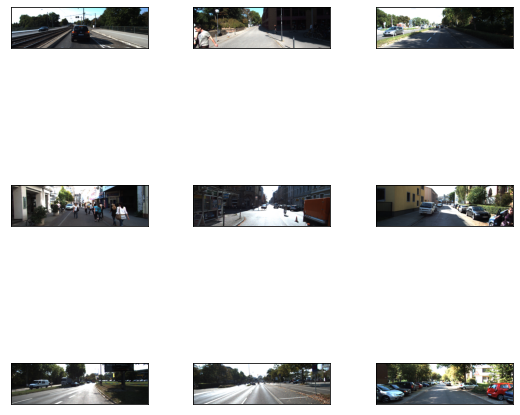

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

    * 데이터 라벨 확인

In [8]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

    * 데이터 셋 확인

In [9]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 1.74,  1.25,  1.37, -1.69, -2.87,  1.68, -1.6 , -2.21, -1.92],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.18136   , 0.        , 0.45717335, 0.10510467],
       [0.33418667, 0.8492995 , 0.58842665, 0.9986876 ],
       [0.33845332, 0.7364976 , 0.5682667 , 0.8496779 ],
       [0.41021332, 0.30752012, 0.5105867 , 0.35309985],
       [0.44746667, 0.44641706, 0.5588    , 0.52416265],
       [0.42432   , 0.15085346, 0.50629336, 0.18583736],
       [0.47250667, 0.27931562, 0.5313333 , 0.29880837],
       [0.00266667, 0.4983253 , 0.6396    , 0.8265861 ],
       [0.28456   , 0.38590983, 0.49088   , 0.4961433 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.43, 1.74, 3.63],
       [1.52, 1.55, 3.91],
       [1.62, 1.84, 4.1 ],
       [1.38, 1.73, 3.97],
       [1.74, 1.58, 3.9 ],
  

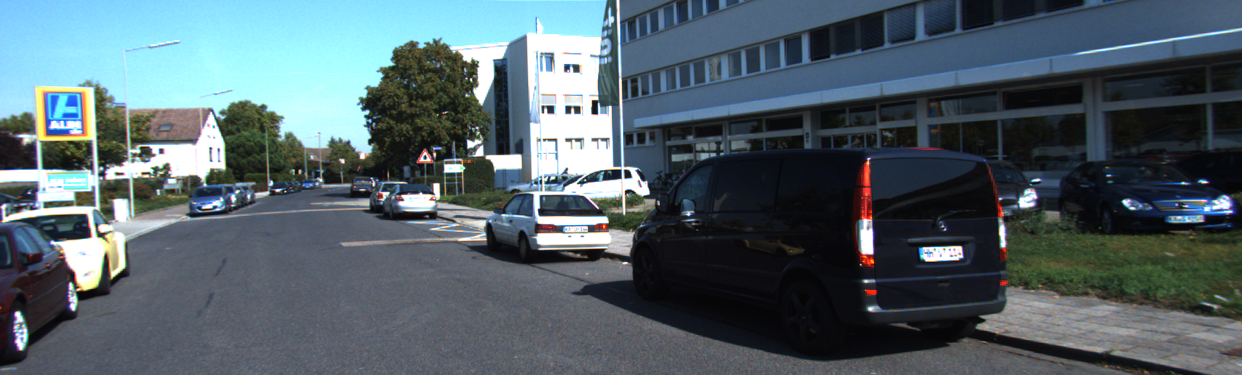

In [10]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

    * 바운딩 박스 시각화

1242 375
(9, 4)
[[   0.       306.99     130.54     203.56   ]
 [1054.83     249.68    1240.37     154.34001]
 [ 914.73     248.08    1055.2999   161.9    ]
 [ 381.94     221.17     438.55002  183.53   ]
 [ 554.45     207.2      651.01     165.45001]
 [ 187.35999  215.87999  230.81     185.13998]
 [ 346.91     197.81     371.12     175.75   ]
 [ 618.92     374.      1026.62     135.15001]
 [ 479.30002  268.29     616.21     190.92   ]]
[  0.   306.99 130.54 203.56]
[1054.83     249.68    1240.37     154.34001]
[ 914.73    248.08   1055.2999  161.9   ]
[381.94    221.17    438.55002 183.53   ]
[554.45    207.2     651.01    165.45001]
[187.35999 215.87999 230.81    185.13998]
[346.91 197.81 371.12 175.75]
[ 618.92     374.      1026.62     135.15001]
[479.30002 268.29    616.21    190.92   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F8664027310>


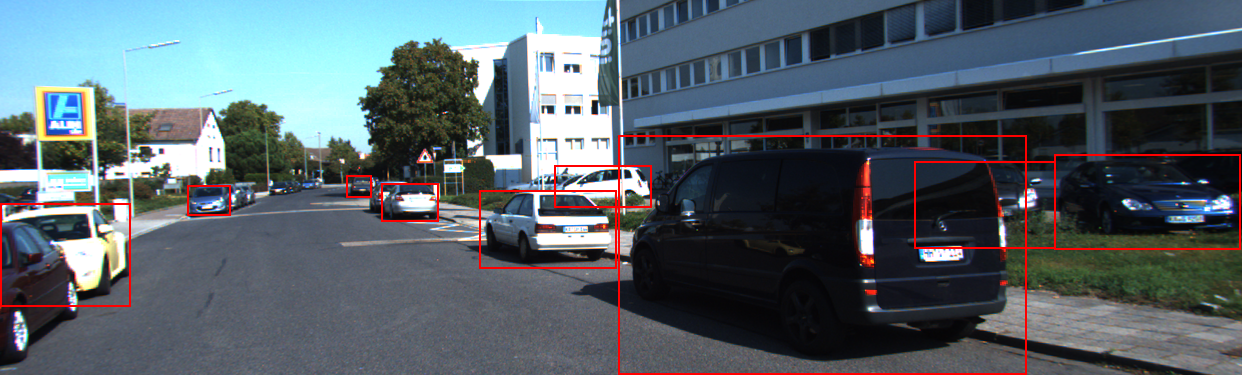

In [11]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

    * 클래스 및 바운딩 박스 정보 추출

In [12]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 class를 확인하여 class에 따른 index를 확인
    # 기존의 class를 차와 사람으로 나눈 것
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append 수행
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [10:46<00:00,  9.82it/s]


    * 클래스 맵핑

In [13]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

    * 모델 훈련

In [18]:
# RetinaNet 훈련, 50epoch 훈련에 1시간 이상 소요
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2020-11-03 15:18:52.506968: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 15:18:53.235353: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 15:18:53.257415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 15:18:53.257823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-03 15:18:53.257838: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 15:18:53.258675: I tensorflow/stream_executor/platform

res4c_branch2a_relu (Activation (None, None, None, 2 0           bn4c_branch2a[0][0]              
__________________________________________________________________________________________________
padding4c_branch2b (ZeroPadding (None, None, None, 2 0           res4c_branch2a_relu[0][0]        
__________________________________________________________________________________________________
res4c_branch2b (Conv2D)         (None, None, None, 2 589824      padding4c_branch2b[0][0]         
__________________________________________________________________________________________________
bn4c_branch2b (BatchNormalizati (None, None, None, 2 1024        res4c_branch2b[0][0]             
__________________________________________________________________________________________________
res4c_branch2b_relu (Activation (None, None, None, 2 0           bn4c_branch2b[0][0]              
__________________________________________________________________________________________________
res4c_bran

Epoch 1/50
2020-11-03 15:31:38.957437: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-11-03 15:31:39.894285: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-11-03 15:31:39.932409: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-11-03 15:31:40.230605: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - ETA: 0s - loss: 3.3690 - regression_loss: 2.6028 - classification_loss: 0.7662
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 56s 286ms/step - loss: 3.3690 - regression_loss: 2.6028 - classification_loss: 0.76

195/195 [==============================] - ETA: 0s - loss: 1.3878 - regression_loss: 1.0792 - classification_loss: 0.3086
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 56s 286ms/step - loss: 1.3878 - regression_loss: 1.0792 - classification_loss: 0.3086
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.3682 - regression_loss: 1.0560 - classification_loss: 0.3122
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
195/195 [==============================] - 56s 285ms/step - loss: 1.3682 - regression_loss: 1.0560 - classification_loss: 0.3122
Epoch 18/50
195/195 [==============================] - ETA: 0s - loss: 1.3674 - regression_loss: 1.0627 - classification_loss: 0.3048
Epoch 00018: saving model to ./snapshots/resnet50_csv_18.h5
195/195 [==============================] - 56s 285ms/step - loss: 1.3674 - regression_loss: 1.0627 - classification_loss: 0.3048
Epoch 19/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 0.9779 - regression_loss: 0.7322 - classification_loss: 0.2458
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
195/195 [==============================] - 56s 285ms/step - loss: 0.9779 - regression_loss: 0.7322 - classification_loss: 0.2458
Epoch 34/50
195/195 [==============================] - ETA: 0s - loss: 0.9626 - regression_loss: 0.7302 - classification_loss: 0.2324
Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
195/195 [==============================] - 56s 285ms/step - loss: 0.9626 - regression_loss: 0.7302 - classification_loss: 0.2324
Epoch 35/50
195/195 [==============================] - ETA: 0s - loss: 0.8745 - regression_loss: 0.6458 - classification_loss: 0.2287
Epoch 00035: saving model to ./snapshots/resnet50_csv_35.h5
195/195 [==============================] - 56s 285ms/step - loss: 0.8745 - regression_loss

Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 0.9147 - regression_loss: 0.6875 - classification_loss: 0.2272
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.
195/195 [==============================] - 56s 286ms/step - loss: 0.9147 - regression_loss: 0.6875 - classification_loss: 0.2272
Epoch 50/50
195/195 [==============================] - ETA: 0s - loss: 0.8670 - regression_loss: 0.6591 - classification_loss: 0.2080
Epoch 00050: saving model to ./snapshots/resnet50_csv_50.h5
195/195 [==============================] - 56s 286ms/step - loss: 0.8670 - regression_loss: 0.6591 - classification_loss: 0.2080


    * 케라스 모델 변환

In [ ]:
    # compile model
model.compile(
    loss={
        'regression'    : losses.smooth_l1(),
        'classification': losses.focal()
    },
    optimizer=keras.optimizers.Adam(lr=lr, clipnorm=optimizer_clipnorm)
)

In [31]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-11-03 17:02:31.848679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 17:02:32.747255: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 17:02:32.769153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 17:02:32.769578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-11-03 17:02:32.769613: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 17:02:32.770556: I tensorflow/stream_executor/platform

In [30]:
import tensorflow as tf
print(tf.__version__)

2.3.1


    * 시각화

In [32]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


In [34]:
def focal(alpha=0.25, gamma=2.0, cutoff=0.5):
    """ Create a functor for computing the focal loss.

    Args
        alpha: Scale the focal weight with alpha.
        gamma: Take the power of the focal weight with gamma.
        cutoff: Positive prediction cutoff for soft targets

    Returns
        A functor that computes the focal loss using the alpha and gamma.
    """
    def _focal(y_true, y_pred):
        """ Compute the focal loss given the target tensor and the predicted tensor.

        As defined in https://arxiv.org/abs/1708.02002

        Args
            y_true: Tensor of target data from the generator with shape (B, N, num_classes).
            y_pred: Tensor of predicted data from the network with shape (B, N, num_classes).

        Returns
            The focal loss of y_pred w.r.t. y_true.
        """
        labels         = y_true[:, :, :-1]
        anchor_state   = y_true[:, :, -1]  # -1 for ignore, 0 for background, 1 for object
        classification = y_pred

        # filter out "ignore" anchors
        indices        = tensorflow.where(keras.backend.not_equal(anchor_state, -1))
        labels         = tensorflow.gather_nd(labels, indices)
        classification = tensorflow.gather_nd(classification, indices)

        # compute the focal loss
        alpha_factor = keras.backend.ones_like(labels) * alpha
        alpha_factor = tensorflow.where(keras.backend.greater(labels, cutoff), alpha_factor, 1 - alpha_factor)
        focal_weight = tensorflow.where(keras.backend.greater(labels, cutoff), 1 - classification, classification)
        focal_weight = alpha_factor * focal_weight ** gamma

        cls_loss = focal_weight * keras.backend.binary_crossentropy(labels, classification)

        # compute the normalizer: the number of positive anchors
        normalizer = tensorflow.where(keras.backend.equal(anchor_state, 1))
        normalizer = keras.backend.cast(keras.backend.shape(normalizer)[0], keras.backend.floatx())
        normalizer = keras.backend.maximum(keras.backend.cast_to_floatx(1.0), normalizer)

        return keras.backend.sum(cls_loss) / normalizer

    return _focal


def smooth_l1(sigma=3.0):
    """ Create a smooth L1 loss functor.

    Args
        sigma: This argument defines the point where the loss changes from L2 to L1.

    Returns
        A functor for computing the smooth L1 loss given target data and predicted data.
    """
    sigma_squared = sigma ** 2

    def _smooth_l1(y_true, y_pred):
        """ Compute the smooth L1 loss of y_pred w.r.t. y_true.

        Args
            y_true: Tensor from the generator of shape (B, N, 5). The last value for each box is the state of the anchor (ignore, negative, positive).
            y_pred: Tensor from the network of shape (B, N, 4).

        Returns
            The smooth L1 loss of y_pred w.r.t. y_true.
        """
        # separate target and state
        regression        = y_pred
        regression_target = y_true[:, :, :-1]
        anchor_state      = y_true[:, :, -1]

        # filter out "ignore" anchors
        indices           = tensorflow.where(keras.backend.equal(anchor_state, 1))
        regression        = tensorflow.gather_nd(regression, indices)
        regression_target = tensorflow.gather_nd(regression_target, indices)

        # compute smooth L1 loss
        # f(x) = 0.5 * (sigma * x)^2          if |x| < 1 / sigma / sigma
        #        |x| - 0.5 / sigma / sigma    otherwise
        regression_diff = regression - regression_target
        regression_diff = keras.backend.abs(regression_diff)
        regression_loss = tensorflow.where(
            keras.backend.less(regression_diff, 1.0 / sigma_squared),
            0.5 * sigma_squared * keras.backend.pow(regression_diff, 2),
            regression_diff - 0.5 / sigma_squared
        )

        # compute the normalizer: the number of positive anchors
        normalizer = keras.backend.maximum(1, keras.backend.shape(indices)[0])
        normalizer = keras.backend.cast(normalizer, dtype=keras.backend.floatx())
        return keras.backend.sum(regression_loss) / normalizer

    return _smooth_l1

In [38]:
# compile model
model.compile(
    loss={
        'regression'    : smooth_l1(),
        'classification': focal()
    },
    optimizer=keras.optimizers.Adam(lr=1e-5, clipnorm=0.001)
)

[593.4253  174.54034 626.831   205.68631]
0
###
[193.74562 130.086   347.37183 229.94476]
0
###
[259.62115 191.17363 485.4949  373.6249 ]
0
###


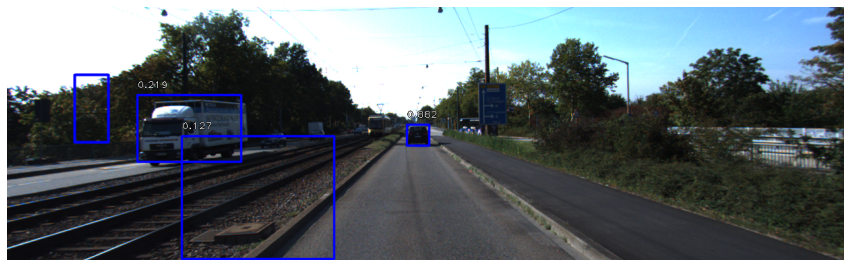

In [60]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.1:
                break
            print(box)
            
            # test용 코드
            print(label)
            print("###")
  
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
        
            # test용 코드
            sample_b = [100, 100, 150, 200]
            
            draw_box(draw, sample_b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

 ## 6-8. 프로젝트: 자율주행 보조 시스템 만들기
 
 ### 1. 자율주행 시스템 만들기
 
    - 입력으로 이미지 경로를 받습니다.
    - 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
    - 조건은 다음과 같습니다.
        - 사람이 한 명 이상 있는 경우
        - 차량의 크기(width or height)가 300px이상인 경우


In [73]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'


def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # test 용 코드
#         print(label)
#         print(box[3]-box[1])
#         print(type(box))
        if label == 1:
            return "Stop"
        
        elif box[2]-box[0] >= size_limit:
            return "Stop"
        
        elif box[3]-box[1] >= size_limit:
            return "Stop"
        
        else:
            return "Go"
             
print(self_drive_assist(img_path))    

Stop


### 2. 자율주행 시스템 평가하기

    - test_system() 를 통해서 위에서 만든 함수를 평가
    - 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가

In [74]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.
